In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import time
from skopt import gp_minimize
from skopt.space import Real, Integer
import abc
import matplotlib.patches as patches

In [2]:
class LatticeBase(abc.ABC):
    def __init__(self, size):
        self.size = size
        self.lattice = None

    @abc.abstractmethod
    def initialize(self):
        pass

    @abc.abstractmethod
    def get_random_site(self):
        pass

    @abc.abstractmethod
    def get_neighbors(self, site):
        pass

    @abc.abstractmethod
    def get_occupancy(self):
        pass

    @abc.abstractmethod
    def plot(self, title="Estado de la red", figsize=(6,6)):
        pass


In [3]:
class SquareLattice(LatticeBase):
    def __init__(self, size):
        super().__init__(size)
        self.lattice = np.zeros((size, size), dtype=int)

    def initialize(self):
        self.lattice.fill(0)

    def get_random_site(self):
        i, j = np.random.randint(0, self.size, size=2)
        return (i, j)

    def get_neighbors(self, site):
        i, j = site
        return [(ni, nj) for ni, nj in [(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
                if 0 <= ni < self.size and 0 <= nj < self.size]

    def get_occupancy(self):
        return np.sum(self.lattice == 1) / (self.size ** 2)

    def plot(self, title="Red cuadrada", figsize=(6,6)):
        fig, ax = plt.subplots(figsize=figsize)
        for i in range(self.size):
            for j in range(self.size):
                color = "black" if self.lattice[i, j] == 1 else "white"
                rect = patches.Rectangle((j, self.size - i - 1), 1, 1, edgecolor='gray', facecolor=color)
                ax.add_patch(rect)
        ax.set_xlim(0, self.size)
        ax.set_ylim(0, self.size)
        ax.set_title(title)
        ax.axis('off')
        plt.show()


In [4]:
import matplotlib.patches as patches
import numpy as np

class HexagonalLattice(LatticeBase):
    def __init__(self, size):
        super().__init__(size)
        self.lattice = np.zeros((size, size), dtype=int)

    def initialize(self):
        self.lattice.fill(0)

    def get_random_site(self):
        i, j = np.random.randint(0, self.size, size=2)
        return (i, j)

    def get_neighbors(self, site):
        i, j = site

        # Definición de vecinos para layout even-r (fila par desplazada)
        if i % 2 == 0:  # Fila par
            deltas = [(-1, 0), (-1, -1),
                    (0, -1),  (0, +1),
                    (+1, 0), (+1, -1)]
        else:  # Fila impar
            deltas = [(-1, +1), (-1, 0),
                    (0, -1),  (0, +1),
                    (+1, +1), (+1, 0)]

        neighbors = [(i + di, j + dj) for di, dj in deltas
                    if 0 <= i + di < self.size and 0 <= j + dj < self.size]

        return neighbors

    def get_occupancy(self):
        return np.sum(self.lattice == 1) / (self.size ** 2)

    def plot(self, title="Red hexagonal", figsize=(6, 6)):
        import matplotlib.pyplot as plt
        import matplotlib.patches as patches

        fig, ax = plt.subplots(figsize=figsize)

        dx = 3 ** 0.5  # horizontal spacing
        dy = 1.5       # vertical spacing
        radius = 0.5

        for i in range(self.size):
            for j in range(self.size):
                x = dx * j + (dx / 2 if i % 2 else 0)
                y = dy * i
                color = "black" if self.lattice[i, j] == 1 else "white"

                hexagon = patches.RegularPolygon(
                    (x, y),
                    numVertices=6,
                    radius=radius,
                    orientation=np.radians(30),
                    edgecolor='gray',
                    facecolor=color,
                    linewidth=0.5
                )
                ax.add_patch(hexagon)

        ax.set_aspect('equal')
        ax.set_xlim(-1, dx * self.size + 1)
        ax.set_ylim(-1, dy * self.size + 1)
        ax.set_title(title)
        ax.axis('off')
        plt.tight_layout()
        plt.show()




In [ ]:
class KineticMonteCarlo:
    def __init__(self, lattice, T, processes, time_array, time_factor=1e-7):
        self.lattice = lattice
        self.T = T
        self.processes = processes
        self.k_b = 8.617e-5
        self.h = 4.136e-15
        self.k_0 = 5
        self.factor = time_factor
        self.time_array = time_array
        self.time = time_array[0]

        self.occupancy = {t: None for t in time_array}
        self.events_count = {p: 0 for p in processes}
        self.events_history = {p: [] for p in processes}
        self.times, self.energies = [], []

        self.lattice.initialize()

    # =======================
    #   Transiciones y tasas
    # =======================

    def pick_random_site(self):
        return self.lattice.get_random_site()

    def count_occupied_neighbors(self, site):
        return sum(self.lattice.lattice[n] for n in self.lattice.get_neighbors(site))

    def calculate_transition_rates(self, site):
        n_ij = self.count_occupied_neighbors(site)
        rates = {}

        if "adsorption" in self.processes:
            p = self.processes["adsorption"]
            E_ads = p["e_ads"] + p.get("e_int_abs", 0) * n_ij
            rates["adsorption"] = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_ads / (self.k_b * self.T))

        if "desorption" in self.processes:
            p = self.processes["desorption"]
            E_des = p["e_des"] + p.get("e_int_des", 0) * n_ij
            rates["desorption"] = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_des / (self.k_b * self.T))

        if "diffusion" in self.processes:
            e_diff = self.processes["diffusion"]["e_diff"]
            rates["diffusion"] = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-e_diff / (self.k_b * self.T))

        return rates

    def select_event(self, rates):
        total = sum(rates.values())
        r = np.random.rand() * total
        cumulative = 0
        for event, rate in rates.items():
            cumulative += rate
            if r < cumulative:
                return event
        return None

    # ===================
    #     Energía
    # ===================

    def calculate_total_energy(self):
        total_energy = 0
        for i in range(self.lattice.size):
            for j in range(self.lattice.size):
                if self.lattice.lattice[i, j] == 1:
                    n_ij = self.count_occupied_neighbors((i, j))
                    e_ads = self.processes["adsorption"]["e_ads"]
                    e_int_abs = self.processes["adsorption"].get("e_int_abs", 0)
                    total_energy += e_ads + e_int_abs * n_ij
        return total_energy

    # ===================
    #     Simulación
    # ===================

    def run_simulation(self):
        end_time = self.time_array[-1]

        while self.time < end_time:
            self._capture_time_snapshot()

            site = self.pick_random_site()
            rates = self.calculate_transition_rates(site)

            if not rates or sum(rates.values()) == 0:
                break  # Sin eventos posibles

            delta_t = (1 / sum(rates.values())) / self.factor
            self.time += delta_t

            event = self.select_event(rates)
            print(event, delta_t, self.time)
            self._apply_event(event, site)
            self._update_history(event)

        self._capture_remaining_snapshots()
        return self.occupancy

    def _apply_event(self, event, site):
        if event == "adsorption":
            self.lattice.lattice[site] = 1
        elif event == "desorption" and self.lattice.lattice[site] == 1:
            self.lattice.lattice[site] = 0
        elif event == "diffusion" and self.lattice.lattice[site] == 1:
            neighbors = self.lattice.get_neighbors(site)
            vacant = [n for n in neighbors if self.lattice.lattice[n] == 0]
            if vacant:
                new_site = vacant[np.random.randint(len(vacant))]
                self.lattice.lattice[site], self.lattice.lattice[new_site] = 0, 1

    def _update_history(self, event):
        self.events_count[event] += 1
        for key in self.events_history:
            self.events_history[key].append(self.events_count[key])

    def _capture_time_snapshot(self):
        for t in self.time_array:
            if self.occupancy[t] is None and self.time >= t:
                self.occupancy[t] = self.lattice.get_occupancy() * 100
                self.energies.append(self.calculate_total_energy())

    def _capture_remaining_snapshots(self):
        for t in self.time_array:
            if self.occupancy[t] is None and self.time >= t:
                self.occupancy[t] = self.lattice.get_occupancy() * 100

    # ===================
    #     Utilidades
    # ===================

    def reset_lattice(self): 
        self.lattice.initialize()
        self.occupancy = {t: None for t in self.time_array}

    def plot_lattice(self, *args, **kwargs):
        self.lattice.plot(*args, **kwargs)


adsorption 0.1648552148864903 0.1648552148864903
adsorption 0.1648552148864903 0.3297104297729806
adsorption 0.1648552148864903 0.4945656446594709
adsorption 0.1648552148864903 0.6594208595459612
adsorption 0.1648552148864903 0.8242760744324515
adsorption 0.1648552148864903 0.9891312893189419
adsorption 0.1648552148864903 1.1539865042054323
adsorption 0.1648552148864903 1.3188417190919226
adsorption 0.1648552148864903 1.483696933978413
adsorption 0.1648552148864903 1.6485521488649033
adsorption 0.1648552148864903 1.8134073637513937
adsorption 0.1648552148864903 1.978262578637884
adsorption 0.1648552148864903 2.1431177935243744
adsorption 0.1648552148864903 2.3079730084108645
adsorption 0.1648552148864903 2.4728282232973546
adsorption 0.1648552148864903 2.6376834381838448
adsorption 0.1648552148864903 2.802538653070335
adsorption 0.1648552148864903 2.967393867956825
adsorption 0.1648552148864903 3.132249082843315
adsorption 0.1648552148864903 3.2971042977298053
adsorption 0.164855214886

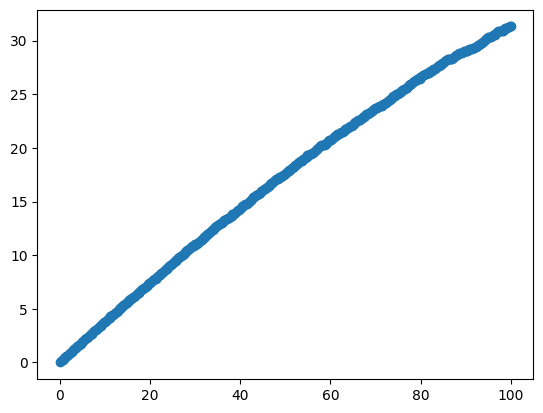

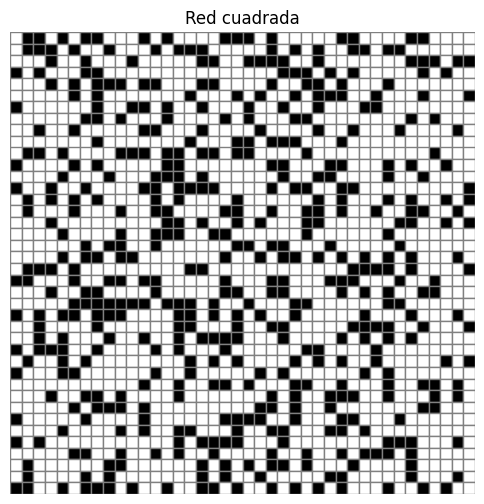

In [6]:

processes = {
    "adsorption": {"e_ads": 0.34}
}
T = 300
time_array = np.linspace(0,100,500)
lattice_size = 40

# Elegí la red: Square o Hexagonal
lattice = SquareLattice(size=lattice_size)  # o HexagonalLattice(size=10)

# Crear y correr el modelo
kmc = KineticMonteCarlo(lattice=lattice, T=T, processes=processes, time_array=time_array)
occupancy = kmc.run_simulation()

# Ver resultados básicos
print("Ocupación final:", occupancy[time_array[-1]])
print("Energía final:", kmc.calculate_total_energy())

print(kmc.events_count)
simulated_data = occupancy.values()
plt.plot(time_array,simulated_data, marker='o', label='Simulation data')
kmc.plot_lattice()


## Conclusiones 

Intentando justificar el modelo, quise, por ejemplo, simular un comportamiento lineal en la curva de ocupación. Antes de eso, es importante considerar que los deltas de tiempo son variables, incluso cuando no se tienen múltiples tasas de transición; esto se debe a que el delta depende del logaritmo de un número aleatorio. Esta es la razón por la cual, aun considerando solo la adsorción, se obtienen buenos acercamientos a las curvas experimentales.

Para poder simular un crecimiento lineal, es necesario reemplazar ese factor aleatorio —el logaritmo de un número uniformemente distribuido entre 0 y 1— por un valor fijo.

Aun así, el crecimiento no será perfectamente lineal, ya que el modelo puede intentar ocupar un sitio que ya esté ocupado, y ese evento no contribuye al incremento de la ocupación.

In [23]:
class KineticMonteCarlo1:
    def __init__(self, lattice, T, processes, time_array, time_factor=1e-7):
        self.lattice = lattice
        self.T = T
        self.processes = processes
        self.k_b = 8.617e-5
        self.h = 4.136e-15
        self.k_0 = 5
        self.factor = time_factor
        self.time_array = time_array
        self.time = time_array[0]

        self.occupancy = {t: None for t in time_array}
        self.events_count = {p: 0 for p in processes}
        self.events_history = {p: [] for p in processes}
        self.times, self.energies = [], []
        self.lattices = []

        self.lattice.initialize()

    # =======================
    #   Transiciones y tasas
    # =======================

    def pick_random_site(self):
        return self.lattice.get_random_site()

    def count_occupied_neighbors(self, site):
        return sum(self.lattice.lattice[n] for n in self.lattice.get_neighbors(site))

    def calculate_transition_rates(self, site):
        n_ij = self.count_occupied_neighbors(site)
        rates = {}

        if "adsorption" in self.processes:
            p = self.processes["adsorption"]
            E_ads = p["e_ads"] + p.get("e_int_abs", 0) * n_ij
            rates["adsorption"] = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_ads / (self.k_b * self.T))

        if "desorption" in self.processes:
            p = self.processes["desorption"]
            E_des = p["e_des"] + p.get("e_int_des", 0) * n_ij
            rates["desorption"] = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_des / (self.k_b * self.T))

        if "diffusion" in self.processes:
            p = self.processes["diffusion"]
            E_diff = p["e_diff"] + p.get("e_int_diff", 0) * n_ij
            rates["diffusion"] = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_diff / (self.k_b * self.T))

        return rates

    def select_event(self, rates):
        total = sum(rates.values())
        r = np.random.rand() * total
        cumulative = 0
        for event, rate in rates.items():
            cumulative += rate
            if r < cumulative:
                return event
        return None

    # ===================
    #     Energía
    # ===================

    def calculate_total_energy(self):
        total_energy = 0
        for i in range(self.lattice.size):
            for j in range(self.lattice.size):
                if self.lattice.lattice[i, j] == 1:
                    n_ij = self.count_occupied_neighbors((i, j))
                    e_ads = self.processes["adsorption"]["e_ads"]
                    e_int_abs = self.processes["adsorption"].get("e_int_abs", 0)
                    total_energy += e_ads + e_int_abs * n_ij
        return total_energy

    # ===================
    #     Simulación
    # ===================

    def run_simulation(self):
        end_time = self.time_array[-1]

        while self.time < end_time:
            self._capture_time_snapshot()

            site = self.pick_random_site()
            rates = self.calculate_transition_rates(site)

            

            if not rates or sum(rates.values()) == 0:
                break  # Sin eventos posibles

            delta_t = (-np.log(np.random.rand()) / sum(rates.values())) / self.factor
            self.time += delta_t

            event = self.select_event(rates)
            self._apply_event(event, site)
            self._update_history(event)

        self._capture_remaining_snapshots()
        return self.occupancy

    def _apply_event(self, event, site):
        if event == "adsorption":
            self.lattice.lattice[site] = 1
        elif event == "desorption" and self.lattice.lattice[site] == 1:
            self.lattice.lattice[site] = 0
        elif event == "diffusion" and self.lattice.lattice[site] == 1:
            neighbors = self.lattice.get_neighbors(site)
            vacant = [n for n in neighbors if self.lattice.lattice[n] == 0]
            if vacant:
                new_site = vacant[np.random.randint(len(vacant))]
                self.lattice.lattice[site], self.lattice.lattice[new_site] = 0, 1

    def _update_history(self, event):
        self.events_count[event] += 1
        for key in self.events_history:
            self.events_history[key].append(self.events_count[key])

    def _capture_time_snapshot(self):
        for t in self.time_array:
            if self.occupancy[t] is None and self.time >= t:
                self.occupancy[t] = self.lattice.get_occupancy() * 100
                self.energies.append(self.calculate_total_energy())
                self.lattices.append(self.lattice.lattice.copy())

    def _capture_remaining_snapshots(self):
        for t in self.time_array:
            if self.occupancy[t] is None and self.time >= t:
                self.occupancy[t] = self.lattice.get_occupancy() * 100

    # ===================
    #     Utilidades
    # ===================

    def reset_lattice(self): 
        self.lattice.initialize()
        self.occupancy = {t: None for t in self.time_array}

    def plot_lattice(self, *args, **kwargs):
        self.lattice.plot(*args, **kwargs)


Ocupación final: 5.79
Energía final: 196.86000000000163
{'adsorption': 596}


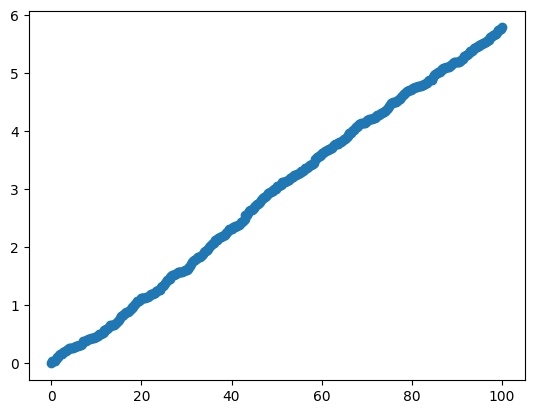

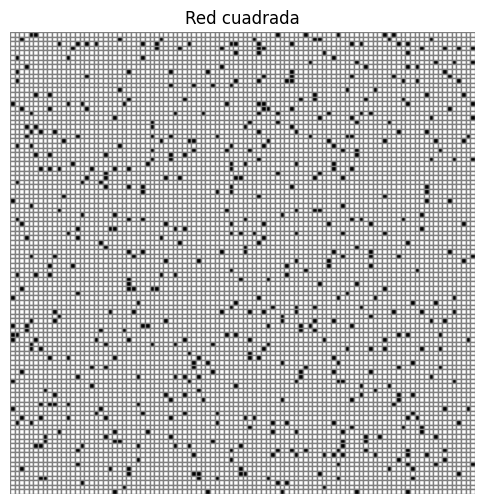

In [8]:

processes = {
    "adsorption": {"e_ads": 0.34}
}
T = 300
time_array = np.linspace(0,100,500)
lattice_size = 100

# Elegí la red: Square o Hexagonal
lattice = SquareLattice(size=lattice_size)  # o HexagonalLattice(size=10)

# Crear y correr el modelo
kmc = KineticMonteCarlo1(lattice=lattice, T=T, processes=processes, time_array=time_array)
occupancy = kmc.run_simulation()

# Ver resultados básicos
print("Ocupación final:", occupancy[time_array[-1]])
print("Energía final:", kmc.calculate_total_energy())

print(kmc.events_count)
simulated_data = occupancy.values()
plt.plot(time_array,simulated_data, marker='o', label='Simulation data')
kmc.plot_lattice()


Cuando se consideran los deltas de tiempo aleatorios, es posible simular un comportamiento lineal en la curva de ocupación, especialmente en redes grandes. Como es de esperarse, la curva presenta ruido debido a la naturaleza aleatoria de los deltas, pero aun así se aproxima muy bien a una línea recta. Este sería el caso en el que el modelo solo permite procesos de adsorción y, además, siempre que se escoge un sitio, este puede ser adsorbido exitosamente. En este caso solo consideramos un único parámetro que es la enegía base de adsorción


Ocupación final: 0.01
Energía final: 0.34
{'adsorption': 1}


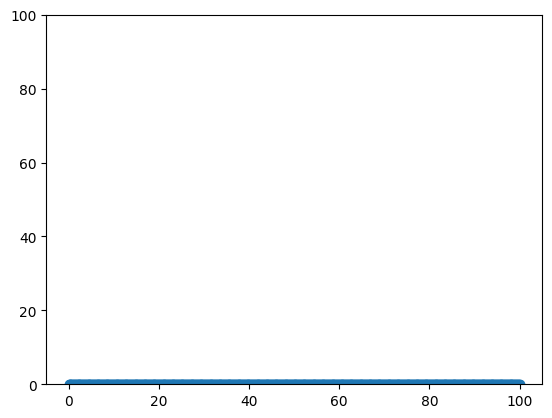

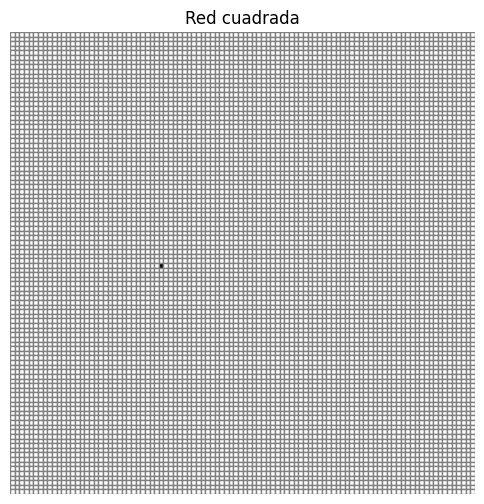

In [9]:

processes = {
    "adsorption": {"e_ads": 0.34}
}
T = 100
time_array = np.linspace(0,100,500)
lattice_size = 100

# Elegí la red: Square o Hexagonal
lattice = SquareLattice(size=lattice_size)  # o HexagonalLattice(size=10)

# Crear y correr el modelo
kmc = KineticMonteCarlo1(lattice=lattice, T=T, processes=processes, time_array=time_array)
occupancy = kmc.run_simulation()

# Ver resultados básicos
print("Ocupación final:", occupancy[time_array[-1]])
print("Energía final:", kmc.calculate_total_energy())

print(kmc.events_count)
simulated_data = occupancy.values()
plt.plot(time_array,simulated_data, marker='o', label='Simulation data')
plt.ylim(0,100)
kmc.plot_lattice()

Tener una temperatura baja se traduce en una baja tasa de adsorción. Esto se debe a que la adsorción es un proceso activado térmicamente: la probabilidad de que una partícula se adsorba depende de superar una barrera energética, lo cual está mediado por la temperatura. Por lo tanto, desde un punto de vista físico, una temperatura baja implica una menor probabilidad de que ocurra la adsorción, lo que equivale a una menor tasa de adsorción en el modelo.

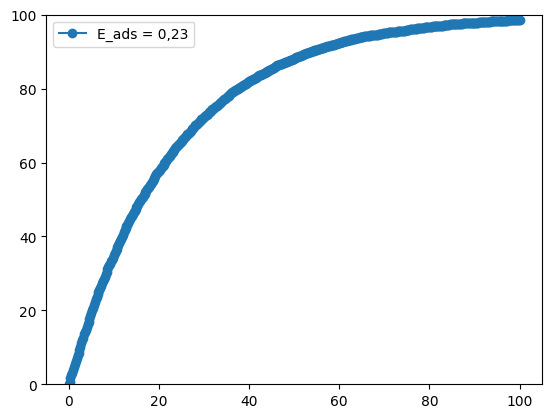

In [20]:
e_ads1, e_ads2, e_ads3, e_ads4 = 0.34, 0.29, 0.23, 0.23

processes1 = {
    "adsorption": {"e_ads": e_ads1}
}

processes2 = {
    "adsorption": {"e_ads": e_ads2}
}

processes3 = {
    "adsorption": {"e_ads": e_ads3}
}

processes4 = {
    "adsorption": {"e_ads": e_ads4, "e_int_abs": 0}
}

T = 300
time_array = np.linspace(0,100,500)
lattice_size = 100

# Elegí la red: Square o Hexagonal
lattice1 = SquareLattice(size=lattice_size)  # o HexagonalLattice(size=10)
lattice2 = SquareLattice(size=lattice_size) 
lattice3 = SquareLattice(size=lattice_size) 
lattice4 = SquareLattice(size=lattice_size)

# Crear y correr el modelo
kmc1 = KineticMonteCarlo1(lattice=lattice1, T=T, processes=processes1, time_array=time_array)
kmc2 = KineticMonteCarlo1(lattice=lattice2, T=T, processes=processes2, time_array=time_array)
kmc3 = KineticMonteCarlo1(lattice=lattice3, T=T, processes=processes3, time_array=time_array)
kmc4 = KineticMonteCarlo1(lattice=lattice4, T=T, processes=processes4, time_array=time_array)
occupancy1 = kmc1.run_simulation()
occupancy2 = kmc2.run_simulation()
occupancy3 = kmc3.run_simulation()
occupancy4 = kmc4.run_simulation()


simulated_data1 = occupancy1.values()
simulated_data2 = occupancy2.values()
simulated_data3 = occupancy3.values()
simulated_data4 = occupancy4.values()

# plt.plot(time_array,simulated_data1, marker='o', label='E_ads = 0,34')
# plt.plot(time_array,simulated_data2, marker='o', label='E_ads = 0,29')
# plt.plot(time_array,simulated_data3, marker='o', label='E_ads = 0,23')
plt.plot(time_array,simulated_data4, marker='o', label='E_ads = 0,23')
plt.ylim(0,100)
plt.legend()

Disminuir `E_ads` se traduce en un aumento de la pendiente de la curva de ocupación, lo que implica una mayor tasa de adsorción. Es decir, el sistema permite que las partículas se adsorban más rápidamente. Sin embargo, como el modelo solo permite adsorción y no desorción, eventualmente se alcanzan sitios ya ocupados, y en esos casos la ocupación no cambia, lo que lleva a una saturación del sistema.

Físicamente, reducir `E_ads` significa que la barrera energética que debe superar una partícula para adsorberse es menor, y por tanto, el proceso se vuelve más probable. Esto es coherente con la forma funcional de la tasa de transición, que depende exponencialmente del negativo de la energía:

$$ k ∝ exp(-E_ads / (k_B * T)) $$

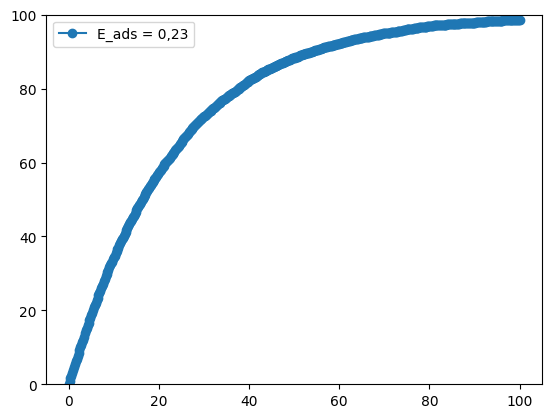

In [24]:
e_ads4 =  0.23

processes4 = {
    "adsorption": {"e_ads": e_ads4, "e_int_abs": 0}
}

T = 300
time_array = np.linspace(0,100,500)
lattice_size = 100

# Elegí la red: Square o Hexagonal

lattice4 = SquareLattice(size=lattice_size)

# Crear y correr el modelo
kmc4 = KineticMonteCarlo1(lattice=lattice4, T=T, processes=processes4, time_array=time_array)

occupancy4 = kmc4.run_simulation()


simulated_data4 = occupancy4.values()

# plt.plot(time_array,simulated_data1, marker='o', label='E_ads = 0,34')
# plt.plot(time_array,simulated_data2, marker='o', label='E_ads = 0,29')
# plt.plot(time_array,simulated_data3, marker='o', label='E_ads = 0,23')
plt.plot(time_array,simulated_data4, marker='o', label='E_ads = 0,23')
plt.ylim(0,100)
plt.legend()

In [25]:
kmc4.lattices

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 1, 0, ..., 0, 0, 0],
   